## Binary classifier

Make our own random data from sklearn's datasets.

In [2]:
from sklearn.datasets import make_circles
import torch
from torch import nn

In [3]:
# make 1000 samples
n_samples = 1000

X,y = make_circles(n_samples=n_samples, 
                    noise=0.03,
                    random_state=42)
print(len(X), len(y))
print(f"First samples of X:\n {X[:5]}\nFirst samples of y:\n {y[:5]}")

1000 1000
First samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First samples of y:
 [1 1 1 1 0]


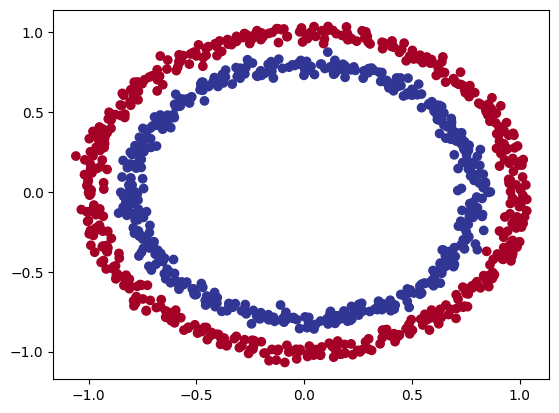

In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], 
                        "X2": X[:,1],
                        "label": y})
circles.head()

import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: This data is essentiall a toy data set - small enough to experiment with but large enough for the fundamentals to be checked.

In [5]:
# Check IO Shapes
print(type(X), type(y))
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [6]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)
print(len(X_train))

800


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

class circle_binary_classifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.Layer1 = nn.Linear(in_features=2, out_features= 5)
        self.Layer2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, model: torch.Tensor) -> torch.Tensor:
        return self.Layer2(self.Layer1(model))
model_0 = circle_binary_classifier().to(device)
model_0

circle_binary_classifier(
  (Layer1): Linear(in_features=2, out_features=5, bias=True)
  (Layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.ReLU(),
                        nn.Linear(in_features=5, out_features=1),
                        nn.ReLU()).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): ReLU()
)

In [25]:
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}\nShape: {untrained_preds.shape}")
print(f"First 10 predictions: {X_test[:10]}\nFirst 10 labels: {y_test[:10]}")
with torch.inference_mode():
    print(f"First untrained preds: {untrained_preds[:10]}")

Length of predictions: 200
Shape: torch.Size([200, 1])
First 10 predictions: tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438],
        [ 0.6323, -0.5711],
        [ 0.8561,  0.5499],
        [ 1.0034,  0.1903],
        [-0.7489, -0.2951],
        [ 0.0538,  0.9739]], device='cuda:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')
First untrained preds: tensor([[ 0.2012],
        [ 0.2933],
        [-0.0926],
        [ 0.2846],
        [-0.1756],
        [-0.1188],
        [ 0.2064],
        [ 0.1097],
        [-0.0887],
        [ 0.2985]], device='cuda:0', requires_grad=True)
X_train shape: torch.Size([10, 2])


In [10]:
# loss_fn = nn.BCELoss() -> Requires inputs to have gone through Sigmoid activation
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.005)

In [11]:
# Calculate accuracy

def accuracy_fn(y_true, y_pred) -> int:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred) * 100) 
    return acc

In [12]:
epochs = 1000
torch.cuda.manual_seed(42)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss = loss_fn(torch.sigmoid(y_logits), y_train)
    loss = loss_fn(y_logits, y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Train Accuracy: {acc}\n Test Loss: {test_loss}, Test Accuracy: {test_acc}")


Epoch: 0 | Loss: 0.7517617344856262, Train Accuracy: 50.0
 Test Loss: 0.7448949813842773, Test Accuracy: 50.0
Epoch: 10 | Loss: 0.7490435838699341, Train Accuracy: 50.0
 Test Loss: 0.7423737645149231, Test Accuracy: 50.0
Epoch: 20 | Loss: 0.7464707493782043, Train Accuracy: 50.0
 Test Loss: 0.7399949431419373, Test Accuracy: 50.0
Epoch: 30 | Loss: 0.7440328001976013, Train Accuracy: 50.0
 Test Loss: 0.7377434968948364, Test Accuracy: 50.0
Epoch: 40 | Loss: 0.7417207360267639, Train Accuracy: 50.0
 Test Loss: 0.7356148958206177, Test Accuracy: 50.0
Epoch: 50 | Loss: 0.7395284175872803, Train Accuracy: 50.0
 Test Loss: 0.7335995435714722, Test Accuracy: 50.0
Epoch: 60 | Loss: 0.7374483942985535, Train Accuracy: 50.0
 Test Loss: 0.7316895127296448, Test Accuracy: 50.0
Epoch: 70 | Loss: 0.7354751229286194, Train Accuracy: 50.0
 Test Loss: 0.7298809885978699, Test Accuracy: 50.0
Epoch: 80 | Loss: 0.7336018085479736, Train Accuracy: 50.0
 Test Loss: 0.7281680107116699, Test Accuracy: 50.0
Ep

From the metrics, it looks like the model is just about flipping a coin. 

Let's visualize what's going on.

In [13]:
import requests 
from pathlib import Path

if Path("helperfunctions.py").is_file():
    print("Helper function script already exists. Pass through")
else:
    print("Grabbing helper functions script")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


Grabbing helper functions script


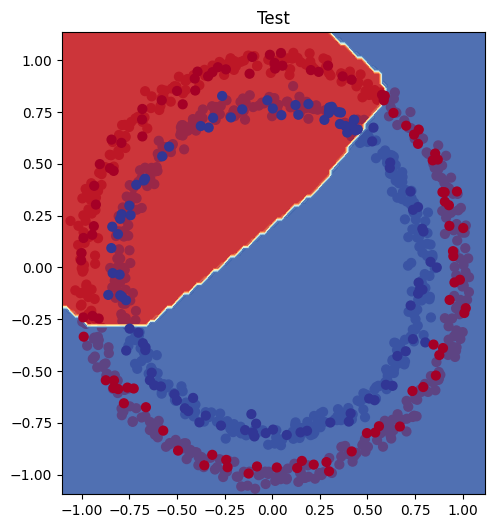

In [20]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,1)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test) 

Let's change the class to make non-linear inferences.

In [30]:
class circle_classifier_v2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, model: torch.Tensor) -> torch.Tensor:
        x = self.layer_1(model)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        return x
model_1 = circle_classifier_v2().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [40]:
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epochs in range(epochs):
    model_1.train() # sets the model into training mode which is important for Dropout and BatchNorm

    # zero grad 
    model_1.zero_grad()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epochs % 100 == 0:
        print(f"Epoch: {epochs} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.62672, Accuracy: 72.75% | Test Loss: 0.64081, Test Accuracy: 64.50%
Epoch: 100 | Loss: 0.62306, Accuracy: 73.88% | Test Loss: 0.63752, Test Accuracy: 65.50%
Epoch: 200 | Loss: 0.61919, Accuracy: 74.88% | Test Loss: 0.63400, Test Accuracy: 66.50%
Epoch: 300 | Loss: 0.61508, Accuracy: 76.00% | Test Loss: 0.63023, Test Accuracy: 68.50%
Epoch: 400 | Loss: 0.61067, Accuracy: 76.75% | Test Loss: 0.62613, Test Accuracy: 68.50%
Epoch: 500 | Loss: 0.60593, Accuracy: 78.00% | Test Loss: 0.62168, Test Accuracy: 70.50%
Epoch: 600 | Loss: 0.60086, Accuracy: 78.88% | Test Loss: 0.61694, Test Accuracy: 73.00%
Epoch: 700 | Loss: 0.59543, Accuracy: 79.75% | Test Loss: 0.61176, Test Accuracy: 75.50%
Epoch: 800 | Loss: 0.58953, Accuracy: 81.38% | Test Loss: 0.60609, Test Accuracy: 78.50%
Epoch: 900 | Loss: 0.58294, Accuracy: 83.38% | Test Loss: 0.59977, Test Accuracy: 80.50%


In [41]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

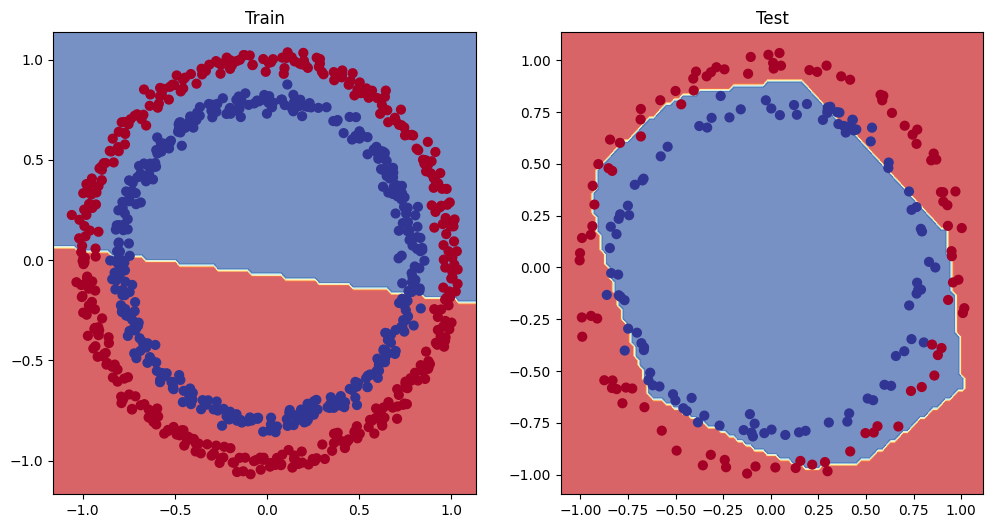

In [42]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)